# Detect Stars in Image

Code taken from [Blob Detection](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html) using the Determinant of Hessian (DoH) algorithm. Extended with the algorithm to fit a 2D-Gaussian through the first identified star to get focus quality.

## Imports

In [ ]:
import cv2;
import numpy as np;
from matplotlib import pyplot as plt;
import matplotlib.patches as patches;
from skimage.feature import blob_doh
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize

## Read image, convert it to grayscale and plot it.

In [ ]:
img = cv2.imread('../tests/image20190915222325.png', cv2.IMREAD_GRAYSCALE)
#ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
plt.figure(figsize=(15,15))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('image20190915222325.png')
plt.tight_layout()
plt.show()

## Detect Blobs

In [12]:
sigma = 20
thresh = 0.02
blobs = blob_doh(img, max_sigma=sigma, threshold=thresh)

## Show blob center coordinates and 2D array of pixels around first itentified center

In [13]:
print('%d blobs found' % len(blobs))
print(blobs[0,0:2])
starblob = img[int(blobs[0,0]-sigma):int(blobs[0,0]-sigma)+2*sigma,int(blobs[0,1]-sigma):int(blobs[0,1]-sigma)+2*sigma]
print(starblob)

2 blobs found
[ 990. 1247.]
[[41 43 41 ... 43 44 43]
 [44 41 43 ... 45 45 44]
 [45 42 46 ... 44 48 46]
 ...
 [45 47 45 ... 46 46 46]
 [48 46 45 ... 47 49 49]
 [46 48 46 ... 48 48 49]]


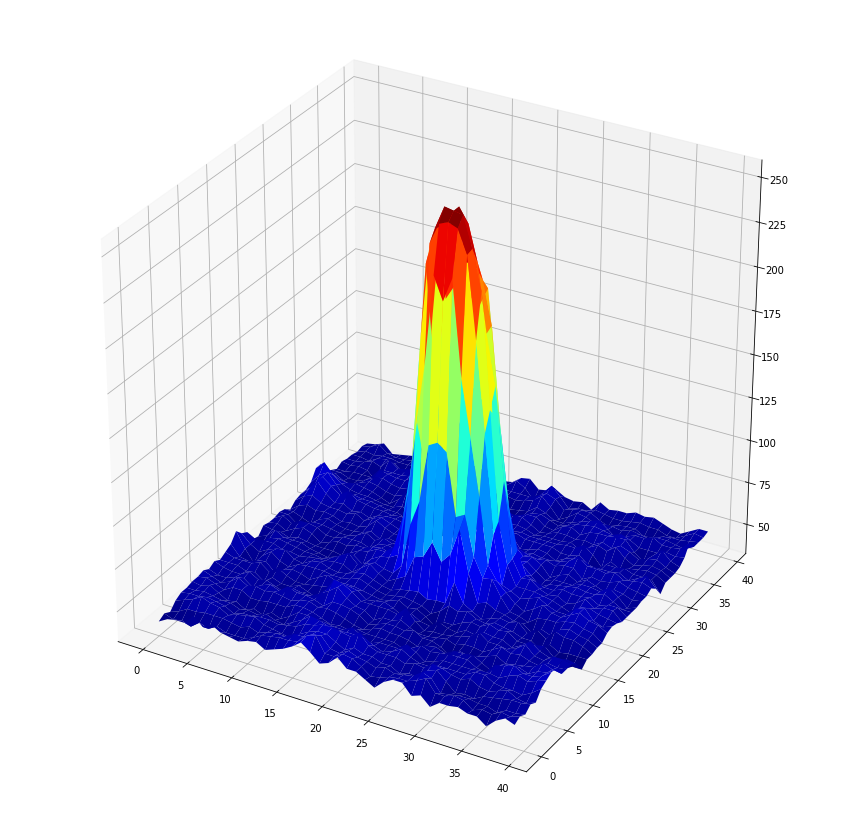

In [14]:
# create the x and y coordinate arrays (here we just use pixel indices)
Xin, Yin = np.mgrid[0:starblob.shape[0], 0:starblob.shape[1]]

# create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.plot_surface(Xin, Yin, starblob ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)

# show it
plt.show()

## Define 2D Gaussian Function for fitting through star blob data. Taken from [Fitting a 2D gaussian](https://scipy-cookbook.readthedocs.io/items/FittingData.html)

In [15]:
def gaussian(height, center_x, center_y, sigma_x, sigma_y):
    """Returns a gaussian function with the given parameters"""
    sigma_x = float(sigma_x)
    sigma_y = float(sigma_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/sigma_x)**2+((center_y-y)/sigma_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

#plt.matshow(starblob, cmap=plt.cm.gist_earth_r)

#params = fitgaussian(starblob)
#fit = gaussian(*params)

#plt.contour(fit(*np.indices(starblob.shape)), cmap=plt.cm.copper)
#ax = plt.gca()
#(height, x, y, width_x, width_y) = params

#plt.text(0.95, 0.05, """
#x : %.1f
#y : %.1f
#width_x : %.1f
#width_y : %.1f""" %(x, y, width_x, width_y),
#        fontsize=16, horizontalalignment='right',
#        verticalalignment='bottom', transform=ax.transAxes);

## Plot Image with identified blobs marked with red circles

In [16]:
params = fitgaussian(starblob)+[0,blobs[0,0]-sigma,blobs[0,1]-sigma,0,0]
fit = gaussian(*params)

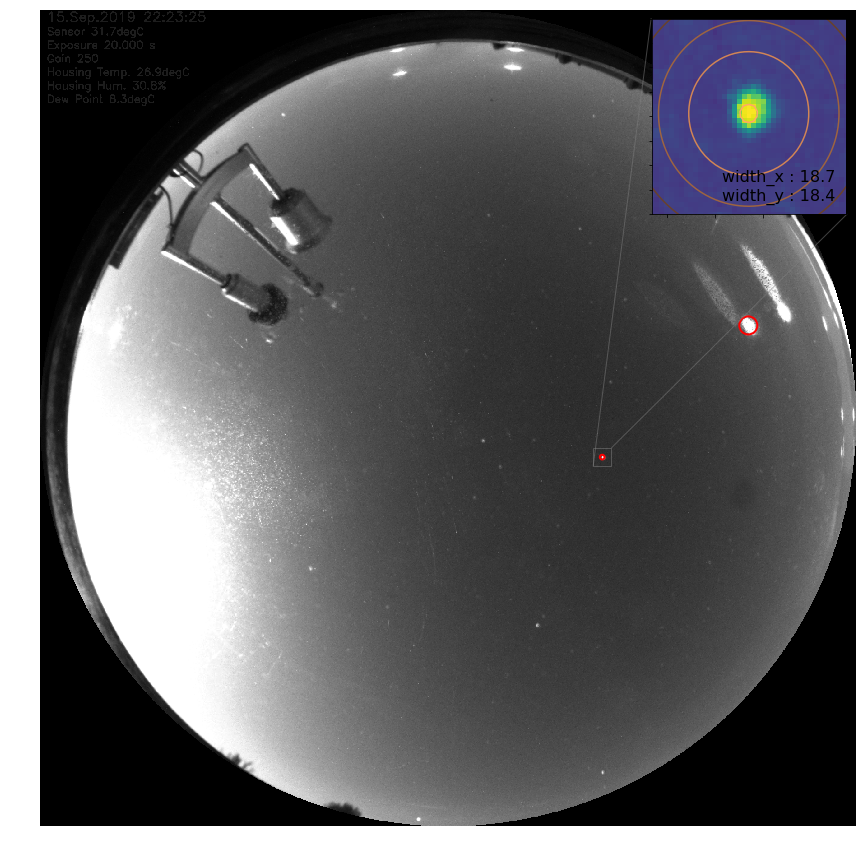

In [17]:
# Create figure and axes
fig,ax = plt.subplots(1,figsize=(15,15))
# Display the image
ax.imshow(img,cmap='gray')
ax.axis('off')
for blob in blobs:
        y, x, r = blob
        c = patches.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
# inset axes....
axins = ax.inset_axes([0.75, 0.75, 0.24, 0.24])
axins.imshow(img, interpolation="nearest", origin="lower")
axins.contour(fit(*np.indices(img.shape)), 6, cmap=plt.cm.copper)
(height, x, y, width_x, width_y) = params

axins.text(0.95, 0.05, """
width_x : %.1f
width_y : %.1f""" %(width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=axins.transAxes);
# sub region of the original image
x1, x2, y1, y2 = blobs[0,1]-sigma, blobs[0,1]+sigma, blobs[0,0]-sigma, blobs[0,0]+sigma
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)

fig.show()